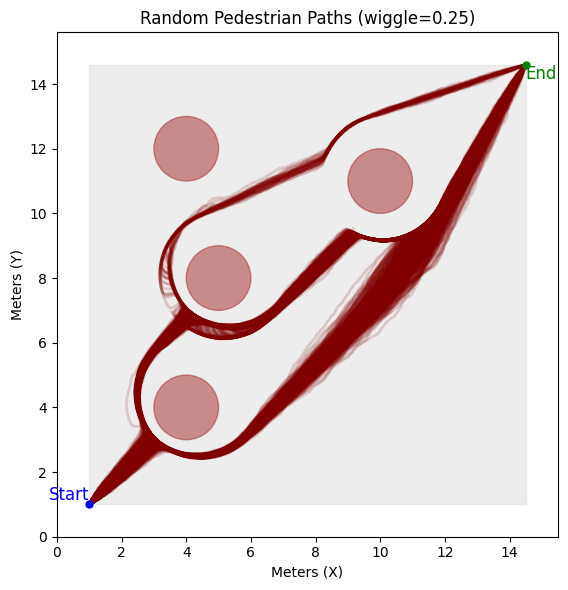

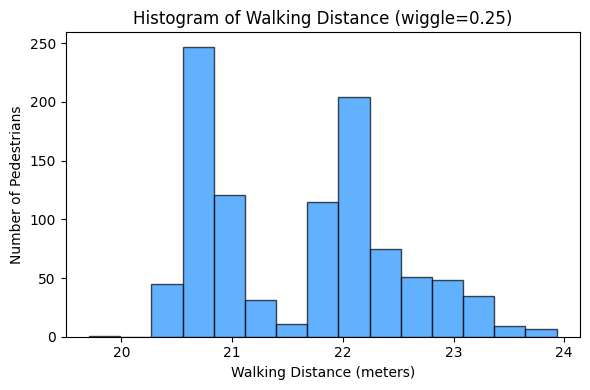

In [40]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

width, height = 15.5, 15.6
margin = 1    # sidewalk setback from edges
start_point = np.array([margin, margin])
end_point = np.array([width-margin, height-margin])

# Crosswalk rectangle bounds
xmin, xmax = margin, width-margin
ymin, ymax = margin, height-margin

obstacles = [
    {'center': [4, 4], 'radius': 1.0},
    {'center': [10, 11], 'radius': 1.0},
    {'center': [5, 8], 'radius': 1.0},
    {'center': [4, 12], 'radius': 1.0}
]

def random_clipped_path(start, end, n_steps=80, wiggle=0.25, avoid_factor=1.2,
                        final_push_step=0.08, buffer=1.0,
                        close_enough_radius=0.5, max_extra_steps=300):
    path = [start.copy()]
    position = start.copy().astype(float)
    direction = (end - start) / np.linalg.norm(end - start)
    step_length = np.linalg.norm(end - start) / n_steps

    for i in range(n_steps):
        main_step = direction * step_length * 0.8
        perp = np.array([-direction[1], direction[0]])
        wiggle_amt = np.random.uniform(-wiggle, wiggle) * step_length
        wiggle_step = perp * wiggle_amt
        move = main_step + wiggle_step

        # Obstacle avoidance (SOFT PUSH)
        for obs in obstacles:
            oc = np.array(obs['center'])
            d = position - oc
            dist = np.linalg.norm(d)
            avoid_radius = obs['radius'] + buffer
            if dist < avoid_radius:
                direction_away = d/(dist+1e-6)
                avoid_push = direction_away * ((avoid_radius - dist) * avoid_factor * 0.25)
                move += avoid_push

        # Step & constrain
        position = position + move
        position[0] = np.clip(position[0], xmin, xmax)
        position[1] = np.clip(position[1], ymin, ymax)

        # HARD boundary for obstacles
        for obs in obstacles:
            oc = np.array(obs['center'])
            d = position - oc
            dist = np.linalg.norm(d)
            if dist < obs['radius']:
                if dist == 0:
                    d = np.random.randn(2)
                    d /= np.linalg.norm(d)
                    position = oc + d * obs['radius']
                else:
                    position = oc + d / dist * obs['radius']

        path.append(position.copy())

        if np.linalg.norm(position - end) < close_enough_radius:
            # Inside the "success" region about the endpoint
            break

    # "Try harder": small more steps to see if we can get closer, if not in "end zone"
    extra_steps = 0
    while np.linalg.norm(position - end) >= close_enough_radius and extra_steps < max_extra_steps:
        v_to_goal = end - position
        dist_to_goal = np.linalg.norm(v_to_goal)
        if dist_to_goal < close_enough_radius:
            break
        direction = v_to_goal / (dist_to_goal + 1e-10)
        move = direction * final_push_step * 0.8
        # Add a little jitter
        perp = np.array([-direction[1], direction[0]])
        wiggle_amt = np.random.uniform(-wiggle, wiggle) * final_push_step
        move += perp * wiggle_amt
        # Obstacle soft avoidance buffer
        for obs in obstacles:
            oc = np.array(obs['center'])
            d = position - oc
            dist = np.linalg.norm(d)
            avoid_radius = obs['radius'] + buffer
            if dist < avoid_radius:
                direction_away = d/(dist+1e-6)
                avoid_push = direction_away * ((avoid_radius - dist) * avoid_factor * 0.25)
                move += avoid_push
        position = position + move
        position[0] = np.clip(position[0], xmin, xmax)
        position[1] = np.clip(position[1], ymin, ymax)
        # Hard obstacle boundary
        for obs in obstacles:
            oc = np.array(obs['center'])
            d = position - oc
            dist = np.linalg.norm(d)
            if dist < obs['radius']:
                if dist == 0:
                    d = np.random.randn(2)
                    d /= np.linalg.norm(d)
                    position = oc + d * obs['radius']
                else:
                    position = oc + d / dist * obs['radius']
        path.append(position.copy())
        extra_steps += 1

    # Final reel-in—can we step to the exact endpoint from here? (Check whole final segment)
    can_finish = True
    for obs in obstacles:
        c = np.array(obs['center'])
        for s in np.linspace(0,1,10):
            trial = position + s * (end - position)
            if np.linalg.norm(trial-c) < obs['radius']:
                can_finish = False
                break
        if not can_finish:
            break
    if can_finish and np.linalg.norm(position-end) < (max(close_enough_radius, 1.5*final_push_step)):
        path.append(end.copy())

    return np.array(path)


# ======== Usage Example ========

num_peds = 1000
wiggle_param = 0.25    # Lower is less squiggle (try 0.05 to 0.15)
distance_list = []

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, width)
ax.set_ylim(0, height)
rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='lightgray', alpha=0.4)
ax.add_patch(rect)
ax.set_aspect('equal', adjustable='box')

for obs in obstacles:
    c = plt.Circle(obs['center'], obs['radius'], color='brown', alpha=0.5)
    ax.add_patch(c)

for _ in range(num_peds):
    path = random_clipped_path(start_point, end_point)
    # Distance: sum of straight-line steps between points
    segment_lengths = np.linalg.norm(np.diff(path, axis=0), axis=1)
    path_distance = np.sum(segment_lengths)
    distance_list.append(path_distance)
    ax.plot(path[:,0], path[:,1], alpha=0.16, linewidth=2, color = "maroon")

# Show just the first/last points of the first path for clarity
ax.scatter([start_point[0]], [start_point[1]], color='blue', s=25, zorder=10)
ax.scatter([end_point[0]], [end_point[1]], color='green', s=25, zorder=10)
ax.text(*start_point, 'Start', fontsize=12, va='bottom', ha='right', color='blue')
ax.text(*end_point, 'End', fontsize=12, va='top', ha='left', color='green')
ax.set_title(f"Random Pedestrian Paths")
plt.xlabel("Meters (X)")
plt.ylabel("Meters (Y)")
plt.tight_layout()
plt.show()

# ---- HISTOGRAM of path distances ----
plt.figure(figsize=(6,4))
plt.hist(distance_list, bins=15, color='dodgerblue', edgecolor='k', alpha=0.7)
plt.title(f"Histogram of Walking Distance (wiggle={wiggle_param})")
plt.xlabel('Walking Distance (meters)')
plt.ylabel('Number of Pedestrians')
plt.tight_layout()
plt.show()


